# Notebook with empirical analyses on the influence of confounds in MVPA
In this notebook, we evaluate different strategies to deal with confounds in MVPA on empirical data (see [this notebook](LINK) for analyses of simulated data). Here, we try to predict gender (male/female) from structural MRI data (VBM and TBSS data) in face of the confound 'brain size'. We chose 'brain size' as a confound, because one could argue that overall brain size is not an interesting predictive feature in MVPA analyses, as people usually try to investigate more *local* gender differences in brain structure. Note that we only focus on this use case because the data was available; we do not wish to draw any conclusions from the results of this study apart from the statistical issues.

## Contents
1. Preparation / set-up
2. Loading and organizing data
3. Assess relation between gender, brainsize, and the structural MRI data
4. Test confound control methods

## 1. Preparation / set-up
In this section, we'll make sure everything is set-up to run/reproduce the analyses in this notebook.

### 1.1. First some imports
Make sure you have the following packages:

* `scikit-learn>=0.19`
* `pandas>=0.20.0`
* `seaborn>=0.8.1`
* `tqdm>=4.19.5`
* `numpy>=1.14.0`
* `scipy>=1.0.0`

And additionally our own skbold package (0.4.0, or preferably from the [master branch on github](https://github.com/lukassnoek/skbold)) installed.

You can do this all at once by using the `requirements.txt` file in the root of this repository:

```
$ pip install -r ../requirements.txt
```

... *or* just running the command in the cell below:

In [ ]:
!pip install -r ../requirements.txt

### 1.2. Downloading the data
From the 'root' directory of the cloned repository (`../`), run the command:

```
$ python download_data.py
```

which should download and unzip the data to `<rootdir>/data`. Alternatively, run the command below:

In [ ]:
%run ../download_data.py

Alright, let's start!

## 2. Loading and organizing data
First, let's import the necessary packages, set some defaults for our analyses, and load in the data.

### 2.1. Importing packages and plotting defaults

In [1]:
import os
import os.path as op
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (cross_val_score, permutation_test_score, StratifiedKFold,
                                     permutation_test_score, RepeatedStratifiedKFold)
from sklearn.preprocessing import StandardScaler   
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.externals import joblib as jl
import seaborn as sns
import scipy.stats as stats
from copy import deepcopy
from tqdm import tqdm_notebook, tqdm
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

# Prevent weird warning
tqdm.monitor_interval = 0

# We'll use seaborn for most of the plotting
sns.set(style='whitegrid', context='poster')
rc = {"font.size":25, "axes.titlesize":25, "axes.labelsize":25, 
      "legend.fontsize":15, "xtick.labelsize": 15,
      "ytick.labelsize": 15, "text.usetex": True}

# Set default colors
color_vbm = sns.color_palette("muted")[0]
color_tbss = sns.color_palette("muted")[1] 
colors_modality = [color_vbm] + [color_tbss]

color_baseline = sns.color_palette("Set2", 10)[7]
color_cb = sns.color_palette("Set2")[2]
color_wdcr = sns.color_palette("Set2")[3]
color_fwcr = sns.color_palette("Set2")[4]

### 2.1. Loading in the data
Below we load in the behavioral data (`PIOP1_behav_2017_with_brainsize.tsv`), which includes our factor-to-decode, "Gender", and our confound-of-interest ("brain_size"). The feature 'brain size' was calculated as the total amount of non-zero voxels of each subject's gray-matter segmented T1-weighted structural scan (as segmented by [FSL FAST](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FAST); FSL v5.0).

The voxel patterns are contained in the `Mvp` objects - a data-structure defined in the [skbold](skbold.readthedocs.io) package - in the attribute `X` (a $N$ [subjects] $\times\ K$ [voxels] numpy array). Two sets of voxel patterns are loaded: one with VBM data (processed with the standard [FSL-VBM pipeline](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSLVBM)) and one with skeletonized FA-data (processed with the standard [FSL-TBSS pipeline](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/TBSS) for a total of 217 subjects.

In [2]:
base_dir = op.dirname(os.getcwd())
data_dir = op.join(base_dir, 'data', 'mvp')
behav_file = op.join(data_dir, 'PIOP1_behav_2017_MVCA_with_brainsize.tsv')

# Load in VBM-mvp ...
mvp_vbm = jl.load(op.join(data_dir, 'mvp_vbm.jl'))

# ... and add "Gender" as "y" attribute
mvp_vbm.add_y(behav_file, col_name='Gender', index_col=0, nan_strategy='remove')
mvp_vbm.y -= 1  # recode from [2, 1] to [0, 1] 
mvp_vbm.y = 1 - mvp_vbm.y  # recode from [male=0, female=1] --> [male=1, female=0] 

print("Shape of VBM voxel patterns: %s" % (mvp_vbm.X.shape,))

# Same for TBSS
mvp_tbss = jl.load(op.join(data_dir, 'mvp_tbss.jl'))
mvp_tbss.add_y(behav_file, col_name='Gender', index_col=0, nan_strategy='remove')
mvp_tbss.y -= 1
mvp_tbss.y = 1 - mvp_tbss.y

print("Shape of TBSS voxel patterns: %s" % (mvp_tbss.X.shape,))

/home/lukas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Shape of VBM voxel patterns: (217, 412473)
Shape of TBSS voxel patterns: (217, 128340)


Note that the TBSS Mvp contains way fewer voxels due to the fact that `skbold` already removed all 0 voxels (i.e. voxels outside the TBSS skeleton). 

Let's check out the target variable ($y$, i.e. gender) of the datasets:

In [3]:
print("TBSS, number of target = 1 (women): %i" % mvp_tbss.y.sum())
print("TBSS, number of target = 0 (men): %i" % (mvp_tbss.y == 0).sum())
print("TBSS, percentage women: %.3f" % mvp_tbss.y.mean(), end='\n\n')

print("VBM, number of target = 1 (women): %i" % mvp_vbm.y.sum())
print("VBM, number of target = 0 (men): %i" % (mvp_vbm.y == 0).sum())
print("TBSS, percentage women: %.3f" % mvp_vbm.y.mean())

TBSS, number of target = 1 (women): 95
TBSS, number of target = 0 (men): 122
TBSS, percentage women: 0.438

VBM, number of target = 1 (women): 95
VBM, number of target = 0 (men): 122
TBSS, percentage women: 0.438


Note that the samples (i.e., participants) are exactly the same in the two datasets (VBM and TBSS). Also, as you can see, there is quite a bit of imbalance in the target variable (gender). We'll 'correct' for this by using an 'imbalance-aware' performance metric ('F1 score', more about that later). 

Now, we load in the confound - brain size - from the same file with "behavioral" data.

In [4]:
df = pd.read_csv(behav_file, index_col=0, sep='\t')
df.head()

,Gender,brain_size_GM,brain_size_WM,brain_size_all
sub-0001,2.0,841107.0,582949.0,1333972.0
sub-0002,2.0,NaN,NaN,NaN
sub-0003,1.0,944433.0,681553.0,1515841.0
sub-0004,2.0,868615.0,603197.0,1378513.0
sub-0005,1.0,981713.0,684582.0,1557081.0


Note that not every subject has values for both the "Gender" variable and the "brain_size*" variables. This is because some subjects completed the demographics questionnaire but not the MRI acquisition phase (or vice versa). Below, we extract only the brain-size estimates for subjects that we actually have data from:

In [5]:
confound_vbm = df.loc[mvp_vbm.common_subjects]['brain_size_GM']
confound_tbss = df.loc[mvp_tbss.common_subjects]['brain_size_WM']
print("Shape brainsize (GM) array VBM: %s" % (confound_vbm.shape,))
print("Shape brainsize (WM) array TBSS: %s" % (confound_vbm.shape,))

Shape brainsize (GM) array VBM: (217,)
Shape brainsize (WM) array TBSS: (217,)


### 2.3. Setting analysis parameters
For the first couple of confound strategies (here we call them "scenarios"), we set some default parameters for our MVPA pipelines.

In [6]:
n_folds = 10  # used in stratified K-fold
n_jobs = 8    # for parallel execution of pipelines through joblib

# Make a dict of both Mvps
mvp = dict(VBM=mvp_vbm, TBSS=mvp_tbss)

# ... same for confounds
confound = dict(VBM=confound_vbm[:, np.newaxis], ## Add axis for some matrix algebra later
                TBSS=confound_tbss[:, np.newaxis])

# We're going to evaluate the scenarios for different amounts of voxels
num_vox = np.round(np.logspace(2, 5, num=8)).astype(int)

# We'll use F1-score as an evaluation metric because our classes
# are be slightly imbalanced (i.e. more female than male subjects)
metric = 'f1_macro'

# The default pipeline we'll use: 
# - univariate feature selection (f-test) for the 'best' K voxels
# - zero-mean / unit std scaling
# - linear SVM
pipeline = Pipeline([('ufs', SelectKBest(f_classif, k=None)),
                     ('scaler', StandardScaler()),
                     ('clf', SVC(kernel='linear', class_weight="balanced"))])

## 3. Assessing the relation between gender, brainsize, and the structural MRI data
In the paper we define a confound as "a variable that correlates with the to-be-decoded variable (the target) and is plausibly encoded in the imaging data". As such, we need to establish this for our empirical example.

### 3.1. Is brainsize correlated/predictive of gender?
Before anything else, we should evaluate whether brain-size is truly a confound. We do this in two ways. First, we can simply calculate the [point-biserial correlation](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient) (i.e., a correlation between a continuous and binary variable) between brain size and gender:

In [7]:
for modality in ['VBM', 'TBSS']:
    corr, pval = stats.pearsonr(confound[modality].squeeze(), mvp[modality].y)
    print("Correlation (p-value) between brain-size and gender "
          "for %s: %.3f (%.4f)" % (modality, corr, pval))

Correlation (p-value) between brain-size and gender for VBM: 0.645 (0.0000)
Correlation (p-value) between brain-size and gender for TBSS: 0.588 (0.0000)


Next to calculating the simple correlation, we can also evualate dependence by using the [Same Analysis Approach](https://arxiv.org/abs/1703.06670) (SAA) suggested by Görgen and colleagues. SAA suggests to simply use your potential confound as a single feature in a classification analysis. As such, we use brain size as a single predictor in a model trying to predict gender.

Let's find out:

/home/lukas/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/lukas/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


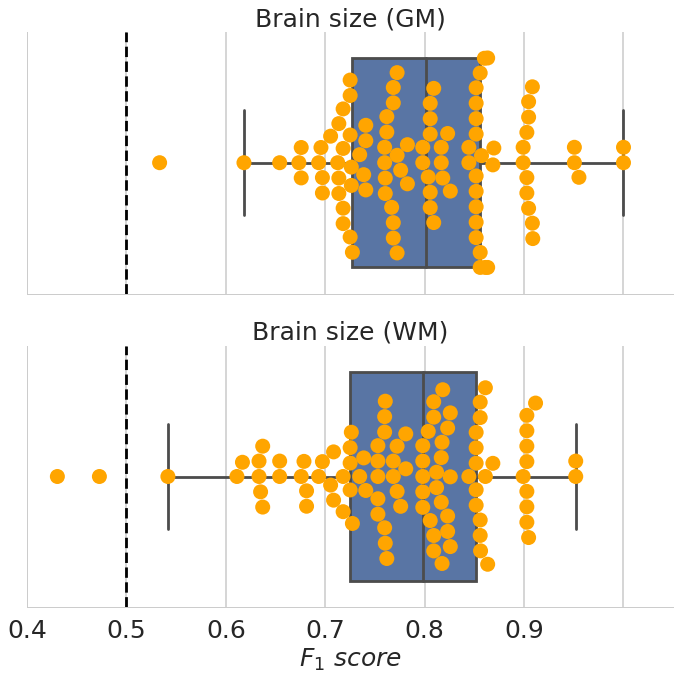

In [8]:
# We leave out univariate feature selection, but include the scaler
pipeline_check = Pipeline([('scaler', StandardScaler()),
                           ('clf', SVC(kernel='linear', class_weight='balanced'))])

# Loop over two modalities
results_check = dict(scores=[], modality=[])
for modality in ['VBM', 'TBSS']:
    this_mvp, this_confound = mvp[modality], confound[modality]
    scores = cross_val_score(pipeline_check, this_confound, this_mvp.y,
                             cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10),
                             scoring=metric, n_jobs=n_jobs)
    results_check['scores'].extend(scores.tolist())
    results_check['modality'].extend([modality.upper()] * scores.size)
    
df_check = pd.DataFrame(results_check)

with sns.plotting_context(rc=rc):
    g = sns.FacetGrid(df_check, row='modality', legend_out=False, size=5, aspect=2)
    g = g.map(sns.boxplot, "scores")
    g = g.map(sns.swarmplot, "scores", size=15, color='orange')
    g = g.map(plt.axvline, x=0.5, c='black', ls='dashed')
    g.axes[0][0].set_title('Brain size (GM)', fontsize=25)
    g.axes[1][0].set_xlabel(r'$F_{1}\ score$', fontsize=25)
    g.axes[1][0].set_title('Brain size (WM)', fontsize=25)
    g.axes[1][0].set_xticklabels(np.round(np.arange(0.4, 1.0, 0.1), 1), fontsize=25)
    plt.xlim(.4, 1.05)
    plt.tight_layout()
    plt.show()

Some descriptive statistics:

In [ ]:
df_check.groupby('modality').agg([np.mean, np.std])

Let's also check whether it's significant using a permutation test (takes a minute or so):

In [ ]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(15, 5))
for i, modality in enumerate(['VBM', 'TBSS']):
    this_mvp, this_confound = mvp[modality], confound[modality]
    perm_results = permutation_test_score(pipeline_check, this_confound,
                                          this_mvp.y, cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=1),
                                          scoring=metric, n_jobs=n_jobs, n_permutations=1000)
    
    axes[i].hist(perm_results[1])
    axes[i].axvline(perm_results[0], c='r', ls='--')
    axes[i].set_title(modality)
    axes[i].set_xlabel(r'$F_1\ score$')
    axes[i].text(0.62, 12, r'$P-value: %.3f$' % perm_results[2], fontsize=12)
    
axes[0].set_ylabel('Frequency')
axes[0].legend(['Permuted scores', 'Observed score'], fontsize=12)
fig.tight_layout()

Conclusion: yes, very accurately and robustly so (p < 0.001)! Thus, we can conclude that 'brainsize' is correlated/predictive of gender.

### 3.1. Is brainsize encoded in the neuroimaging data?
Next, let's assess whether brainsize is actually related ('encoded in') the neuroimaging data. One way to do so is to assess the correlation of each voxel with brainsize. As such, we need to calculate *a lot* of correlations (i.e., one for every voxel); we define (in `utils.py`) a "vectorized" correlation function that is able to calculate a lot of correlations at the same same:

Now, let's calculate the correlation of brainsize with all voxels for both VBM and TBSS:

In [ ]:
from utils import vectorized_corr

corrs_Xc = dict(corrs=[], modality=[])

for modality in ['VBM', 'TBSS']:
    corrs_Xc['corrs'].extend(vectorized_corr(confound[modality], mvp[modality].X))
    corrs_Xc['modality'].extend([modality] * mvp[modality].X.shape[1])

... and plot them (as normalized histograms + KDE plot):

In [ ]:
from utils import rpdf
rs = np.arange(-.5, .5, 0.001)

g = sns.FacetGrid(df_check, col='modality', legend_out=False, size=5, aspect=2)
g = g.map(sns.boxplot, "scores")
g = g.map(sns.swarmplot, "scores", size=15, color='orange')
g = g.map(plt.axvline, x=0.5, c='black', ls='dashed')
g.axes[0][0].set_title('Brain size (GM)', fontsize=25)
g.axes[0][1].set_title('Brain size (WM)', fontsize=25)
g.axes[0][0].set_xlabel(r'$F_{1}\ score$', fontsize=25)
g.axes[0][1].set_xlabel(r'$F_{1}\ score$', fontsize=25)
g.axes[0][1].set_xticklabels(np.round(np.arange(0.4, 1.0, 0.1), 1), fontsize=25)
g.axes[0][0].set_xticklabels(np.round(np.arange(0.4, 1.0, 0.1), 1), fontsize=25)
g.axes[0][0].set_xlim(.4, 1.05)
g.axes[0][1].set_xlim(.4, 1.05)

g = sns.FacetGrid(pd.DataFrame(corrs_Xc), col='modality', hue='modality', legend_out=True,
                  size=4, aspect=2, palette=colors_modality)
g = g.map(sns.distplot, "corrs", norm_hist=False)
g.set(xlabel=r'$r_{X,C}$', title='')
g.axes[0][0].set_title('VBM')
g.axes[0][1].set_title('TBSS')
g.axes[0][0].set_ylabel('Density')
g.axes[0][0].plot(rs, rpdf(rho=0, n=217, rs=rs), ls='--', c=color_vbm)
g.axes[0][1].plot(rs, rpdf(rho=0, n=217, rs=rs), ls='--', c=color_tbss)
g.axes[0][1].set_ylim(0, 6)
g.axes[0][0].legend([r'$PDF(\rho = 0)$', 'Actual correlations'])

g.despine(left=True)
plt.tight_layout()
plt.show()

## 4. Test confound control methods
In this section, we'll actually apply the three confound control methods (post-hoc counterbalancing, whole-dataset confound regression, and our proposed fold-wise confound regression method). We'll start with a baseline model in which no confound control is applied.

### 4.1. Baseline model (no confound control)
Now, for a baseline analysis, let's predict gender based on TBSS and VBM data for different amounts of voxels included in the analyses (as selected by `f_classif`):

In [ ]:
results_baseline = dict(n_vox=[], score=[], modality=[])

for modality in ['VBM', 'TBSS']:
    this_mvp = mvp[modality]
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                         desc='analyzing %s' % modality)):
        
        pipeline.set_params(ufs__k=nV)
        scores = cross_val_score(pipeline, this_mvp.X, this_mvp.y,
                                 cv=n_folds, scoring=metric, n_jobs=n_jobs)
        results_baseline['n_vox'].extend([nV] * n_folds)
        results_baseline['score'].extend(scores.tolist())
        results_baseline['modality'].extend([modality] * n_folds)
        
results_baseline_df = pd.DataFrame(results_baseline)
results_baseline_df['method'] = ['None'] * len(results_baseline_df)

Now, before we plot any of the results, we'll need to run a permutation analysis in which we run the same analysis as above a 1000 times with permuted labels (i.e., $y$ is shuffled). The code is below, but we recommend *not* running it (it takes about 1.5 days).

#### Permutation tests baseline
Only run the cell below if you want to (re)calculate the p-values using the permutation test (this takes quite long):

In [ ]:
save_dir = op.join(base_dir, 'data', 'perm_results', 'baseline')

for modality in ['VBM', 'TBSS']:
    this_mvp = mvp[modality]
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                         desc='analyzing %s' % modality)):
        pipeline.set_params(ufs__k=nV)
        this_score, these_perms, this_pval = permutation_test_score(pipeline, this_mvp.X, this_mvp.y,
                                                                    cv=n_folds, n_permutations=1000,
                                                                    n_jobs=n_jobs, scoring=metric)
        
        this_save_dir = op.join(save_dir, modality, 'K_%i' % nV)
        
        if not op.isdir(this_save_dir):
            os.makedirs(this_save_dir)
            
        np.savez(op.join(this_save_dir, 'perm_data.npz'), obs_score=this_score, perm_scores=these_perms,
                 pval=this_pval)

Now, let's plot the observed score on top of the permutation distributions:

In [ ]:
baseline_perms = np.zeros((2, 9, 1000))
baseline_obs = np.zeros((2, 9))
baseline_pvals = np.zeros((2, 9))

plt.figure(figsize=(15, 25))
this_plot = 1
for i, modality in enumerate(['VBM', 'TBSS']):
    perm_dirs = sorted(glob(op.join(base_dir, 'data', 'perm_results',
                                    'baseline', modality, 'K*', '*npz')),
                       key=lambda x: int(op.basename(op.dirname(x)).split('_')[1]))

    for ii, pdir in enumerate(perm_dirs):
        perm_data = np.load(pdir)
        baseline_perms[i, ii, :] = perm_data['perm_scores']
        baseline_obs[i, ii] = perm_data['obs_score']
        baseline_pvals[i, ii] = perm_data['pval']
        plt.subplot(9, 2, this_plot)
        plt.title('%s, %s' % (modality, op.basename(op.dirname(pdir))))
        plt.hist(baseline_perms[i, ii, :])
        plt.xlim(0.2, 1)
        plt.ylim(0, 300)
        pval = (1 + (baseline_obs[i, ii] <= baseline_perms).sum()) / (baseline_perms[i, ii, :].size + 1)
        plt.text(0.25, 210, "P-val: %.3f" % pval, fontsize=15)
        plt.axvline(baseline_obs[i, ii], c='tab:orange', ls='--')
        
        this_plot += 1

plt.tight_layout()

#### Baseline model performance
Alright, now let's actually plot the observed (mean) model performance for the VBM and TBSS dataset across the different values for $K$ (i.e., amount of voxels). Note the dashed black line is chance level performance (50%) and the dashed orange line is the model performance when using brainsize only (for comparison):

In [ ]:
custom_legend_labels = ['Method = None', 'Chance level performance', 'Brain size only performance']
custom_legend_handles = [plt.Line2D((0, 1), (0, 0), color=color_baseline, marker='o', lw=3),
                         plt.Line2D((0, 1), (0, 0), color='k', ls='--', lw=2),
                         plt.Line2D((0, 1), (0, 0), color='tab:orange', ls='--', lw=1)]

with sns.plotting_context(rc=rc):
    g = sns.factorplot(x='n_vox', y='score', col='modality', hue='modality', palette=[color_baseline] * 2,
                       data=results_baseline_df, size=5, aspect=2, legend_out=True, legend=True)
    g = g.map(plt.axhline, y=0.5, c='black', ls='dashed', lw=2)
    g.set(ylim=(0, 1), ylabel='$\mathrm{F_{1}\ score}$', xlabel='K voxels')
    g.axes[0][1].set_ylabel('')
    g.axes[0][0].axhline(df_check[df_check.modality == 'VBM'].scores.mean(), lw=2, c='orange', ls=':')
    g.axes[0][1].axhline(df_check[df_check.modality == 'TBSS'].scores.mean(), lw=2, c='orange', ls=':')
    g.axes[0][0].legend(custom_legend_handles[0:1], custom_legend_labels[0:1], loc=3, borderaxespad=0.)
    g.axes[0][1].legend(custom_legend_handles[1:], custom_legend_labels[1:], loc=3, borderaxespad=0.)
    g.axes[0][0].set_title("VBM", fontsize=35)
    g.axes[0][1].set_title("TBSS", fontsize=35)
    
    for thisax, mod in enumerate(['VBM', 'TBSS']):
        this_df = results_baseline_df[results_baseline_df.modality == mod]
        scores_per_K = this_df.groupby('n_vox').mean().values
    
        this_range = range(9) if thisax == 1 else [0, 1, 2, 3, 4, 5, 6, 7, 9]
        for i, xval in enumerate(this_range):
            
            if baseline_pvals[thisax, i] <= 0.001:
                g.axes[0][thisax].text(xval - 0.12, scores_per_K[i] + 0.05, '*', fontsize=35)
    
    g.despine(left=True)
plt.show()

As you can see, performance is far above chance, but it is unclear what drives our results: some 'true signal' or 'confounded signal'? To try to disentangle those sources of information, we're going to evaluate post-hoc counterbalancing and (two flavors of) confound regression in the next section.

### 4.2. Counterbalancing
In the post-hoc counterbalancing method, we try to control for confounds by "decorrelating" the confound ($c$) and the target ($y$) by subsampling the data. We've written a scikit-learn style class, `CounterbalancedStratifiedSplit` (which is similar to scikit-learn's `StratifiedKFold`) that subsamples your data until the confound is counterbalanced with respect to the target. Note that this class makes sure to find partitions in which *each fold* is counterbalanced, as advised by [Görgen and colleagues](https://arxiv.org/abs/1703.06670).

The class is contained in a module called `counterbalance.py` in the same directory as this notebook. Let's import it:

In [9]:
from counterbalance import CounterbalancedStratifiedSplit

method_list = [func for func in dir(CounterbalancedStratifiedSplit)
               if callable(getattr(CounterbalancedStratifiedSplit, func)) and not func.startswith("_")]

print("The CounterbalanceStratifiedSplit class has the following methods:\n%s" % (method_list,))

The CounterbalanceStratifiedSplit class has the following methods:
['check_counterbalance_and_subsample', 'split']


As described in our paper, we want to subsample the data until the P-value of the correlation is above some threshold $\alpha$:

\begin{align}
\mathrm{while}\ P(\hat{\rho}_{cy}) < \alpha:
\newline
\mathrm{subsample}(X, y, c)
\end{align}

We'll showcase how this is done on the VBM-data below. We use $\alpha = 0.05$ as a threshold. 

In [10]:
vbm_data = mvp['VBM']
vbm_confound = confound['VBM']
cbss = CounterbalancedStratifiedSplit(X=vbm_data.X, y=vbm_data.y, c=vbm_confound.squeeze(),
                                      c_type='continuous', metric='corr',
                                      use_pval=True, threshold=0.05,
                                      verbose=True, n_splits=n_folds)

First, we need to call the `check_counterbalance_and_subsample()` method to subsample the data (if necessary).

In [11]:
cbss.check_counterbalance_and_subsample()

Current overall correlation c/y (pval): 0.645 (0.000)
Current overall correlation c/y (pval): 0.643 (0.000)
Current overall correlation c/y (pval): 0.641 (0.000)
Current overall correlation c/y (pval): 0.638 (0.000)
Current overall correlation c/y (pval): 0.635 (0.000)
Current overall correlation c/y (pval): 0.632 (0.000)
Current overall correlation c/y (pval): 0.628 (0.000)
Current overall correlation c/y (pval): 0.623 (0.000)
Current overall correlation c/y (pval): 0.619 (0.000)
Current overall correlation c/y (pval): 0.615 (0.000)
Current overall correlation c/y (pval): 0.610 (0.000)
Current overall correlation c/y (pval): 0.605 (0.000)
Current overall correlation c/y (pval): 0.600 (0.000)
Current overall correlation c/y (pval): 0.594 (0.000)
Current overall correlation c/y (pval): 0.589 (0.000)
Current overall correlation c/y (pval): 0.583 (0.000)
Current overall correlation c/y (pval): 0.576 (0.000)
Current overall correlation c/y (pval): 0.570 (0.000)
Current overall correlation 

After subsamping, the `cbss` object has a new attribute, `subsample_idx`, that contains the indices for the subsampled data. So, we can *actually* subsample our data as follows:

In [12]:
X_cb = vbm_data.X[cbss.subsample_idx]
y_cb = vbm_data.y[cbss.subsample_idx]
c_cb = vbm_confound[cbss.subsample_idx]

At this moment, the `cbss` object has found a partitionining (using 10 folds) in which every fold is perfectly counterbalanced in the *subsampled* data. Now, we can just call the `split()` to get the train and test indices for every fold:

In [13]:
for train_idx, test_idx in cbss.split(X_cb, y_cb):
    pass

Alright, now let's apply this to our data. 

In [ ]:
from warnings import filterwarnings
from sklearn.exceptions import UndefinedMetricWarning
# Filter this warning, which occurs when a class is not predicted at all 
# (e.g., all samples are classified as "man", and no "women" predictions are made)
filterwarnings("ignore", category=UndefinedMetricWarning)

results_cb = dict(n_vox=[], score=[], modality=[])

for modality in ['VBM', 'TBSS']:
    
    c = confound[modality]
    this_mvp = mvp[modality]    

    skf = CounterbalancedStratifiedSplit(this_mvp.X, this_mvp.y, c.squeeze(),
                                         # Use P(corr(y, c)) > 0.1 as threshold
                                         c_type='continuous', metric='tstat', use_pval=True, threshold=0.1,
                                         verbose=False, n_splits=n_folds)
    skf.check_counterbalance_and_subsample()
    X, y, c = this_mvp.X[skf.subsample_idx], this_mvp.y[skf.subsample_idx], c[skf.subsample_idx]
    print("Retained %i samples for %s (reduction of %.1f%%)" % (y.size, modality,
                                                                ((this_mvp.y.size - y.size) / this_mvp.y.size)*100))
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                         desc='Evaluating %s' % modality)):
        
        pipeline.set_params(ufs__k=nV)        
        scores = cross_val_score(estimator=pipeline, X=X, y=y, scoring=metric,
                                 cv=StratifiedKFold(n_splits=n_folds))
        results_cb['n_vox'].extend([nV] * n_folds)
        results_cb['score'].extend(scores.tolist())
        results_cb['modality'].extend([modality] * n_folds)

results_cb_df = pd.DataFrame(results_cb)
results_cb_df['method'] = ['Counterbalancing'] * len(results_cb_df)

#### Permutation tests counterbalancing
We'll run the permutation tests again, but now for the counterbalanced data.

In [ ]:
save_dir = op.join(base_dir, 'data', 'perm_results', 'counterbalancing')

for modality in ['VBM', 'TBSS']:
    
    c = confound[modality]
    this_mvp = mvp[modality]    

    skf = CounterbalancedStratifiedSplit(this_mvp.X, this_mvp.y, c.squeeze(),
                                         c_type='continuous', metric='tstat', threshold=0.1,
                                         verbose=False, use_pval=True, n_splits=n_folds)
    skf.check_counterbalance_and_subsample()
    X, y, c = this_mvp.X[skf.subsample_idx], this_mvp.y[skf.subsample_idx], c[skf.subsample_idx]

    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                         desc='Evaluating %s' % modality)):
        
        pipeline.set_params(ufs__k=nV)  
        this_score, these_perms, this_pval = permutation_test_score(pipeline, this_mvp.X, this_mvp.y,
                                                                    cv=n_folds, n_permutations=1000,
                                                                    n_jobs=n_jobs, scoring=metric)
        
        this_save_dir = op.join(save_dir, modality, 'K_%i' % nV)
        
        if not op.isdir(this_save_dir):
            os.makedirs(this_save_dir)
            
        np.savez(op.join(this_save_dir, 'perm_data.npz'), obs_score=this_score, perm_scores=these_perms,
                 pval=this_pval)

... and plot the permutation distributions (note that we reverse the p-value if it drops below chance):

In [ ]:
cb_perms = np.zeros((2, 9, 1000))
cb_obs = np.zeros((2, 9))
cb_pvals = np.zeros((2, 9))

plt.figure(figsize=(15, 25))
this_plot = 1
for i, modality in enumerate(['VBM', 'TBSS']):
    perm_dirs = sorted(glob(op.join(base_dir, 'data', 'perm_results',
                                    'counterbalancing', modality, 'K*', '*npz')),
                       key=lambda x: int(op.basename(op.dirname(x)).split('_')[1]))

    for ii, pdir in enumerate(perm_dirs):
        perm_data = np.load(pdir)
        cb_perms[i, ii, :] = perm_data['perm_scores']
        cb_obs[i, ii] = perm_data['obs_score']
        cb_pvals[i, ii] = perm_data['pval']
        plt.subplot(9, 2, this_plot)
        plt.title('%s, %s' % (modality, op.basename(op.dirname(pdir))))
        plt.hist(cb_perms[i, ii, :])
        plt.xlim(0.2 , 1)
        plt.text(0.25, 210, "P-val: %.3f" % cb_pvals[i, ii], fontsize=15)
        plt.axvline(cb_obs[i, ii], c='tab:orange', ls='--')
        
        this_plot += 1
        
plt.tight_layout()

#### Counterbalanced model performance

In [ ]:
baseline_vs_cb = pd.concat((results_baseline_df, results_cb_df))
colorpalette = [color_baseline] + [color_cb]

custom_legend_labels = ['Method = None', 'Method = Counterbalancing', 'Chance level performance', 'Brain size only performance']
custom_legend_handles = [plt.Line2D((0, 1), (0, 0), color=color_baseline, marker='o', lw=3),
                         plt.Line2D((0, 1), (0, 0), color=color_cb, marker='o', lw=3),
                         plt.Line2D((0, 1), (0, 0), color='k', ls='--', lw=2),
                         plt.Line2D((0, 1), (0, 0), color='tab:orange', ls='--', lw=1)]

with sns.plotting_context(rc=rc):
    g = sns.factorplot(x='n_vox', y='score', col='modality', hue='method', palette=colorpalette,
                       data=baseline_vs_cb, size=5, aspect=2, legend_out=True, legend=False)
    g = g.map(plt.axhline, y=0.5, c='black', ls='dashed', lw=2)
    g.set(ylim=(0, 1), ylabel='$\mathrm{F_{1}\ score}$', xlabel='K voxels')
    g.axes[0][1].set_ylabel('')
    g.axes[0][0].axhline(df_check[df_check.modality == 'VBM'].scores.mean(), lw=2, c='orange', ls=':')
    g.axes[0][1].axhline(df_check[df_check.modality == 'TBSS'].scores.mean(), lw=2, c='orange', ls=':')
    g.axes[0][0].legend(custom_legend_handles[:2], custom_legend_labels[:2], loc=3, borderaxespad=0.)
    g.axes[0][1].legend(custom_legend_handles[2:], custom_legend_labels[2:], loc=3, borderaxespad=0.)
    g.axes[0][0].set_title("VBM", fontsize=35)
    g.axes[0][1].set_title("TBSS", fontsize=35)
    
    for thisax, mod in enumerate(['VBM', 'TBSS']):
        this_df = results_cb_df[results_cb_df.modality == mod]
        scores_per_K = this_df[this_df.method == 'Counterbalancing'].groupby('n_vox').mean().values
    
        this_range = range(9) if thisax == 1 else [0, 1, 2, 3, 4, 5, 6, 7, 9]
        up = 0.06 if thisax == 0 else -0.18
        for i, xval in enumerate(this_range):
            
            if cb_pvals[thisax, i] <= 0.001:
                g.axes[0][thisax].text(xval - 0.12, scores_per_K[i] + up, '*', fontsize=35)
    
    g.despine(left=True)
    plt.show()

That's weird ... Especially with the VBM-data, there seems to be a strong positive bias in the counterbalance-method. What is happening?

Perhaps we can figure out something from the correlation structure before and after subsampling. To do so, we'll calculate the correlations between the voxels and gender both before and after subsampling. 

In [25]:
from utils import vectorized_semipartial_corr, vectorized_corr
results_corr_cb = dict(corrs=[], which_data=[], modality=[])

for modality in ['VBM', 'TBSS']:

    c = confound[modality]
    this_mvp = mvp[modality]
    
    results_corr_cb['corrs'].extend(vectorized_semipartial_corr(this_mvp.y[:, np.newaxis], c, this_mvp.X,
                                                                which='2D'))
    results_corr_cb['which_data'].extend(['Original'] * this_mvp.X.shape[1])
    results_corr_cb['modality'].extend([modality] * this_mvp.X.shape[1])
    
    skf = CounterbalancedStratifiedSplit(this_mvp.X, this_mvp.y, c.squeeze(),
                                         c_type='continuous', metric='corr', threshold=0.1,
                                         verbose=False, use_pval=True, n_splits=n_folds)
    skf.check_counterbalance_and_subsample()
    X, y, c = this_mvp.X[skf.subsample_idx], this_mvp.y[skf.subsample_idx], c[skf.subsample_idx]
    
    results_corr_cb['corrs'].extend(vectorized_semipartial_corr(y[:, np.newaxis], c, X, which='2D'))
    results_corr_cb['which_data'].extend(['Subsampled'] * X.shape[1])
    results_corr_cb['modality'].extend([modality] * X.shape[1])

Now, let's plot the 'before' and 'after' correlation distributions of $\rho(xy)$ for both VBM and TBSS!

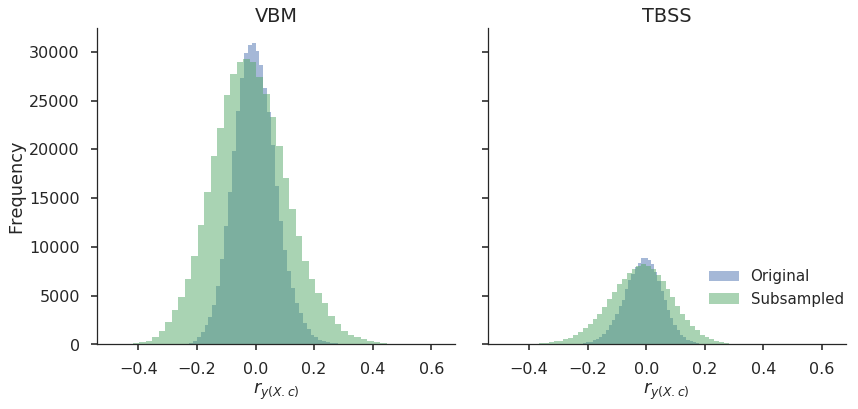

In [49]:
results_corr_cb_df = pd.DataFrame(results_corr_cb)

sns.set_style('ticks')
g = sns.FacetGrid(results_corr_cb_df, col='modality', hue='which_data', size=6)
g.map(plt.hist, 'corrs', alpha=0.5, bins=50)
g.axes[0][1].legend(loc=(0.6, 0.1), fontsize=15)
g.set_axis_labels("$r_{y(X.c)}$", "Frequency")
g.axes[0][0].set_title("VBM")
g.axes[0][1].set_title("TBSS");

This figure is quite telling. The plots of the distribution of correlations between $X$ and $y$ show you that subsamping widens the correlation distribution, meaning that it (artificially) increases the dependence ("signal") between the data ($X$) and the target ($y$).

But *why* does subsampling lead to an (overall) increase in $\rho_{X,y}$? We answer that question in detail in the [notebook with simulations](simulation_confound_methods.ipynb), but we'll try to explain the basics here. Basically, it turns out that subsampling tends to "throw out" samples that contain little signal for features with certain characteristics. After throwing out these low-signal samples, the overall signal (i.e., approximated by $rho_{X,y}$ increases which then yields better performance of the classification model. This happens, generally, for *voxels in which the (partial) correlation between $X$ and $c$ (controlled for $y$) is larger than 

In [52]:
voxel_idx = {}
for modality in ['VBM', 'TBSS']:

    c = confound[modality]
    this_mvp = mvp[modality]
    
    pcorr_Xy = vectorized_semipartial_corr(this_mvp.y, c, this_mvp.X, which='2D')
    pcorr_Xc = vectorized_semipartial_corr(c, this_mvp.y, this_mvp.X, which='2D')
    sortedarr = (pcorr_Xc - pcorr_Xy).argsort()[::-1]
    voxel_idx[modality] = sortedarr[:10]

In [53]:
from scipy.stats import ttest_ind, chisquare
scaler = StandardScaler()
clf = SVC(kernel='linear', class_weight='balanced')
plt.figure(figsize=(15, 15))
for i, modality in enumerate(['VBM', 'TBSS']):

    c = confound[modality]
    this_mvp = mvp[modality]    

    cbss = CounterbalancedStratifiedSplit(this_mvp.X, this_mvp.y, this_confound.squeeze(),
                                          c_type='continuous', metric='tstat', use_pval=True, threshold=0.05,
                                          verbose=False, n_splits=n_folds)
    cbss.check_counterbalance_and_subsample()
    this_ss_X = this_mvp.X[cbss.subsample_idx]
    this_ss_y = this_mvp.y[cbss.subsample_idx]
    this_ss_c = this_confound[cbss.subsample_idx]
    
    before_X = this_mvp.X[:, voxel_idx[modality]]
    print("Before corr(X,y): %.3f" % vectorized_corr(this_mvp.y[:, np.newaxis], before_X).mean())
    after_X = this_ss_X[:, voxel_idx[modality]]
    print("After corr(X,y): %.3f" % vectorized_corr(this_ss_y[:, np.newaxis], after_X).mean())
    
    dtb = np.zeros(this_mvp.y.size)
    scores = np.zeros(this_mvp.y.size)
    skf = StratifiedKFold(n_splits=n_folds)
    for ii, (train_idx, test_idx) in enumerate(skf.split(this_mvp.X, 1-this_mvp.y)):
        Xtrain, Xtest = before_X[train_idx], before_X[test_idx]
        ytrain, ytest = this_mvp.y[train_idx], this_mvp.y[test_idx]
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        clf.fit(Xtrain, ytrain)
        scores[test_idx] = clf.predict(Xtest)
        dtb[test_idx] = clf.decision_function(Xtest)

    scores = (scores == this_mvp.y).astype(int)
    print("Model perf: %.3f" % scores.mean())
    pipeline_check.fit(before_X, this_mvp.y)
    preds = pipeline_check.predict(before_X)
    scores_no_cv = f1_score(this_mvp.y, preds)
    print("Model perf (no cv): %.3f" % scores_no_cv)
    print("Model perf (CB): %.3f" % cross_val_score(pipeline_check, after_X, this_ss_y, cv=cbss).mean())
    idx = cbss.subsample_idx
    nidx = list(set(range(this_mvp.y.size)) - set(idx))
    nonsel = np.zeros(this_mvp.y.size)
    nonsel[nidx] = 1
    ytmp = this_mvp.y.copy()
    ytmp[this_mvp.y == 0] = -1
    print(ttest_ind(nonsel, dtb*ytmp))
    print(chisquare([scores[nonsel == i].sum() for i in [0, 1]]))

Before corr(X,y): -0.169
After corr(X,y): -0.329
Model perf: 0.581
Model perf (no cv): 0.616
Model perf (CB): 0.649
Ttest_indResult(statistic=3.4920893231409056, pvalue=0.0005286298908193787)
Power_divergenceResult(statistic=11.46031746031746, pvalue=0.0007109815319531261)
Before corr(X,y): -0.197
After corr(X,y): -0.362
Model perf: 0.608
Model perf (no cv): 0.646
Model perf (CB): 0.805
Ttest_indResult(statistic=0.45106097778491355, pvalue=0.6521719261169096)
Power_divergenceResult(statistic=22.09090909090909, pvalue=2.600383125978477e-06)


In [ ]:
scaler = StandardScaler()
clf = SVC(kernel='linear', class_weight='balanced')
from scipy.stats import pearsonr
for modality in ['VBM', 'TBSS']:

    c = confound[modality]
    this_mvp = mvp[modality]    

    cbss = CounterbalancedStratifiedSplit(this_mvp.X, this_mvp.y, this_confound.squeeze(),
                                          c_type='continuous', metric='tstat', use_pval=True, threshold=0.05,
                                          verbose=False, n_splits=n_folds)
    cbss.check_counterbalance_and_subsample()
    this_ss_X = this_mvp.X[cbss.subsample_idx]
    this_ss_y = this_mvp.y[cbss.subsample_idx]
    this_ss_c = this_confound[cbss.subsample_idx]

    skf = CounterbalancedStratifiedSplit(this_mvp.X, this_mvp.y, c.squeeze(),
                                         c_type='continuous', metric='corr', threshold=0.05,
                                         verbose=False, use_pval=True, n_splits=n_folds)
    skf.check_counterbalance_and_subsample()
    X, y, c = this_mvp.X[skf.subsample_idx], this_mvp.y[skf.subsample_idx], c[skf.subsample_idx]
    
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                         desc='Evaluating %s' % modality)):

        skb = SelectKBest(f_classif, k=nV)
        skb.fit(this_ss_X, this_ss_y)
        idx = skb.get_support()
        before_X = this_mvp.X[:, idx]
        after_X = this_ss_X[:, idx]

        dtb = np.zeros(this_mvp.y.size)
        scores = np.zeros(this_mvp.y.size)
        skf = StratifiedKFold(n_splits=n_folds)
        for ii, (train_idx, test_idx) in enumerate(skf.split(this_mvp.X, this_mvp.y)):
            Xtrain, Xtest = before_X[train_idx], before_X[test_idx]
            ytrain, ytest = this_mvp.y[train_idx], this_mvp.y[test_idx]
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)
            clf.fit(Xtrain, ytrain)
            scores[test_idx] = clf.predict(Xtest)
            dtb[test_idx] = clf.decision_function(Xtest)

        scores = (scores == this_mvp.y).astype(int)
        idx = cbss.subsample_idx
        nidx = list(set(range(y.size)) - set(idx))
        nonsel = np.zeros(this_mvp.y.size)
        nonsel[nidx] = 1
        ytmp = this_mvp.y.copy()
        ytmp[this_mvp.y == 0] = -1
        print(pearsonr(dtb*ytmp, nonsel))
        print(pearsonr(scores, nonsel), end='\n\n')

In [ ]:
results_cb_bias = dict(corrs=[], modality=[], n_vox=[])

for modality in ['VBM', 'TBSS']:
    this_mvp, this_confound = mvp[modality], confound[modality]
    cbss = CounterbalancedStratifiedSplit(this_mvp.X, this_mvp.y, this_confound.squeeze(),
                                          c_type='continuous', metric='tstat', use_pval=True, threshold=0.05,
                                          verbose=False, n_splits=n_folds)
    cbss.check_counterbalance_and_subsample()
    this_ss_X = this_mvp.X[cbss.subsample_idx]
    this_ss_y = this_mvp.y[cbss.subsample_idx]
    this_ss_c = this_confound[cbss.subsample_idx]
    
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                         desc='Evaluating %s' % modality)):

        skb = SelectKBest(f_classif, k=nV)
        skb.fit(this_ss_X, this_ss_y)
        idx = skb.get_support()
        before_X = this_mvp.X[:, idx]
        after_X = this_ss_X[:, idx]
        
        before_partial_Xc = vectorized_partial_corr(this_confound, this_mvp.y, before_X)
        before_partial_Xy = vectorized_partial_corr(this_mvp.y, this_confound, before_X)
        
        results_cb_bias['corrs'].append((before_partial_Xc - before_partial_Xy).mean())
        results_cb_bias['modality'].append(modality)
        results_cb_bias['n_vox'].append(nV)

In [ ]:
g = sns.factorplot(x='n_vox', y='corrs', hue='modality',
                   data=pd.DataFrame(results_cb_bias), size=5, aspect=2, legend_out=True,
                   legend=True)

In [ ]:
results_cb_bias_df = pd.DataFrame(results_cb_bias)
results_cb_bias_df['method'] = ['bias'] * len(results_cb_bias_df)
results_cb_bias_df['score'] = results_cb_bias_df['corrs']

g = sns.factorplot(x='n_vox', y='score', col='modality', hue='method',
                   data=pd.concat((results_cb_bias_df, results_baseline_df)), size=5, aspect=2, legend_out=True,
                   legend=False)

In [ ]:
results_cb_val_df = pd.DataFrame(results_cb_val)
results_baseline_df['set'] = ['base_val'] * len(results_baseline_df)
results_fwcr_df['set'] = ['fwcr_val'] * len(results_baseline_df)

compare = pd.concat((results_cb_val_df, results_baseline_df, results_fwcr_df))

g = sns.factorplot(x='n_vox', y='score', col='modality', hue='set',# palette=colorpalette,
                   data=compare, size=5, aspect=2, legend_out=True, legend=True)

In [ ]:
tmp_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='linear', class_weight='balanced'))
])

## 4.3: confound regression on entire dataset (WDCR)
First, we'll evaluate the strategy that is sometimes adopted: regressing out the confound from the entire data-set (here: `X`) at once (like in [this article](http://www.sciencedirect.com/science/article/pii/S1053811913002887)), like we did when we compared the correlation distributions of the voxels and gender/brain-size between "uncorrected" and "corrected" data. 

In the rest of the notebook, we'll discuss and demonstrate different ways of regressing out a confound from the data (`X`), and to reduce the boilerplate code, we wrote a custom `scikit-learn`-style "transformer" class that does exactly this: take a confound upon initialization and subsequently fits a model using the confound to predict each feature in `X` during `fit(X)`, and subsequently regresses out the confound from each feature in `X` during `transform(X)` (in a scikit-learn style). 

For more info on the exact implementation of the `ConfoundRegressor` object, check the [skbold Github repo](https://github.com/lukassnoek/skbold/blob/master/skbold/preproc/confounds.py).

Assuming that the latest version of `skbold` is installed on the system, let's import the `ConfoundRegressor` class.

In [54]:
from skbold.preproc.confounds import ConfoundRegressor

To evaluate what happens when we regress out the confound from each voxel before cross-validating our MVPA pipeline, we'll use the `ConfoundRegressor` on the entire dataset. 


In [94]:
results_wdcr = dict(n_vox=[], score=[], modality=[])

for modality in ['VBM', 'TBSS']:
    
    this_mvp = deepcopy(mvp[modality])
    this_confound = confound[modality]
    cfr = ConfoundRegressor(this_confound, this_mvp.X, cross_validate=True)
    this_mvp.X = cfr.fit_transform(this_mvp.X)
    
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                                   desc='analyzing %s' % modality)):
        
        pipeline.set_params(ufs__k=nV)
        scores = cross_val_score(pipeline, this_mvp.X, this_mvp.y,
                                 cv=n_folds, scoring=metric, n_jobs=-1)
        results_wdcr['n_vox'].extend([nV] * n_folds)
        results_wdcr['score'].extend(scores.tolist())
        results_wdcr['modality'].extend([modality] * n_folds)
        
results_wdcr_df = pd.DataFrame(results_wdcr)
results_wdcr_df['method'] = ['WDCR'] * len(results_wdcr_df)

#### Permutation tests WDCR
And calculate the p-values.

In [ ]:
save_dir = op.join(base_dir, 'data', 'perm_results', 'wdcr')

for modality in ['VBM', 'TBSS']:
    this_mvp = mvp[modality]
    this_confound = confound[modality]
    cfr = ConfoundRegressor(this_confound, this_mvp.X, cross_validate=True)
    this_mvp.X = cfr.fit_transform(this_mvp.X)
        
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                         desc='analyzing %s' % modality)):
        
        pipeline.set_params(ufs__k=nV)
        this_score, these_perms, this_pval = permutation_test_score(pipeline, this_mvp.X, this_mvp.y,
                                                                    cv=n_folds, n_permutations=1000,
                                                                    n_jobs=n_jobs, scoring=metric)
        
        this_save_dir = op.join(save_dir, modality, 'K_%i' % nV)
        
        if not op.isdir(this_save_dir):
            os.makedirs(this_save_dir)
            
        np.savez(op.join(this_save_dir, 'perm_data.npz'), obs_score=this_score, perm_scores=these_perms,
                 pval=this_pval)

And plot permutation distributions. Note that we reverse the p-value if the score is below chance (50%):

In [ ]:
wdcr_perms = np.zeros((2, 9, 1000))
wdcr_obs = np.zeros((2, 9))
wdcr_pvals = np.zeros((2, 9))

plt.figure(figsize=(15, 25))
this_plot = 1
for i, modality in enumerate(['VBM', 'TBSS']):
    perm_dirs = sorted(glob(op.join(base_dir, 'data', 'perm_results',
                                    'wdcr', modality, 'K*', '*npz')),
                       key=lambda x: int(op.basename(op.dirname(x)).split('_')[1]))

    for ii, pdir in enumerate(perm_dirs):
        perm_data = np.load(pdir)
        wdcr_perms[i, ii, :] = perm_data['perm_scores']
        wdcr_obs[i, ii] = perm_data['obs_score']
        
        if perm_data['pval'] < 0.5:
            wdcr_pvals[i, ii] = perm_data['pval']
            txt = "P-val: %.3f" % wdcr_pvals[i, ii]
        else:
            wdcr_pvals[i, ii] = 1 - perm_data['pval']
            txt = "P-val: %.3f (< chance)" % wdcr_pvals[i, ii]

        plt.subplot(9, 2, this_plot)
        plt.title('%s, %s' % (modality, op.basename(op.dirname(pdir))))
        plt.hist(wdcr_perms[i, ii, :])
        plt.xlim(0.2 , 1)
        plt.text(0.68, 210, txt, fontsize=15)
        plt.axvline(wdcr_obs[i, ii], c='tab:orange', ls='--')
        
        this_plot += 1
        
plt.tight_layout()

#### Plot WDCR model performance

In [ ]:
baseline_vs_wdcr = pd.concat((results_baseline_df, results_wdcr_df))
colorpalette = [color_baseline] + [color_wdcr]

custom_legend_labels = ['Method = None', 'Method = WDCR', 'Chance level performance', 'Brain size only performance']
custom_legend_handles = [plt.Line2D((0, 1), (0, 0), color=color_baseline, marker='o', lw=3),
                         plt.Line2D((0, 1), (0, 0), color=color_wdcr, marker='o', lw=3),
                         plt.Line2D((0, 1), (0, 0), color='k', ls='--', lw=2),
                         plt.Line2D((0, 1), (0, 0), color='tab:orange', ls='--', lw=1)]

with sns.plotting_context(rc=rc):
    g = sns.factorplot(x='n_vox', y='score', col='modality', hue='method', palette=colorpalette,
                       data=baseline_vs_wdcr, size=5, aspect=2, legend_out=True, legend=False)
    g = g.map(plt.axhline, y=0.5, c='black', ls='dashed', lw=2)
    g.set(ylim=(0, 1), ylabel='$\mathrm{F_{1}\ score}$', xlabel='K voxels')
    g.axes[0][1].set_ylabel('')
    g.axes[0][0].axhline(df_check[df_check.modality == 'VBM'].scores.mean(), lw=2, c='orange', ls=':')
    g.axes[0][1].axhline(df_check[df_check.modality == 'TBSS'].scores.mean(), lw=2, c='orange', ls=':')
    g.axes[0][0].legend(custom_legend_handles[:2], custom_legend_labels[:2], loc=3, borderaxespad=0.)
    g.axes[0][1].legend(custom_legend_handles[2:], custom_legend_labels[2:], loc=3, borderaxespad=0.)
    g.axes[0][0].set_title("VBM", fontsize=35)
    g.axes[0][1].set_title("TBSS", fontsize=35)

    for thisax, mod in enumerate(['VBM', 'TBSS']):
        this_df = results_wdcr_df[results_wdcr_df.modality == mod]
        scores_per_K = this_df[this_df.method == 'WDCR'].groupby('n_vox').mean().values
    
        this_range = range(9) if thisax == 1 else [0, 1, 2, 3, 4, 5, 6, 7, 9]
        for i, xval in enumerate(this_range):
            
            if wdcr_pvals[thisax, i] <= 0.001:
                up = 0.05 if thisax == 1 else -0.18
                g.axes[0][thisax].text(xval - 0.12, scores_per_K[i] + up, '*', fontsize=35)
    
    g.despine(left=True)
    plt.show()

#### What is happening?
We see that classification performance quickly drops under chance level with an increasing number of voxels in our analyses... As we've argue in our paper and show in our simulations (see [this](simulation_confound_strategies) notebook), this is due to the fact that we've regressed out our confound on the *entire data-set (X)*, but then proceed to do K-fold cross-validation, in which (due to sampling error) confounds might still have a (opposite!) effect in train and test. (This point is related to what Görgen et al. mention in [their paper](https://arxiv.org/abs/1703.06670) about the "Same analysis approach"

So, naturally, let's check and see what happens when we fit the confound regression on the train-set only and subsequently use those models to regress the confound on the train- *and* test-set. Or in other words, let's cross-validate our confound-regression

### 4.3. Confound regression per fold (FwCR)
Note that the `ConfoundRegressor` is initialized with an additional parameter now: `cross_validate=True`, which makes sure that when we transform the test-set, it uses the weights from the fitting procedure on the train-set. (In the next scenario, we'll set `cross_validate` to `False` in order to check what happens when we fit it separately to the test-set.)

In [ ]:
results_fwcr = dict(score=[], n_vox=[], modality=[])
    
for modality in ['VBM', 'TBSS']:
    this_mvp = mvp[modality]
    this_confound = confound[modality]
    pipe = deepcopy(pipeline).steps
    cr = ('cr', ConfoundRegressor(this_confound, this_mvp.X, cross_validate=True))
    pipe.insert(0, cr)
    pipe = Pipeline(pipe)
    
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                                   desc='analyzing %s' % modality)):
     
        pipe.set_params(ufs__k=nV)
        scores = cross_val_score(pipe, this_mvp.X, this_mvp.y, cv=n_folds, n_jobs=n_jobs)
        results_fwcr['score'].extend(scores)
        results_fwcr['n_vox'].extend([nV] * scores.size)
        results_fwcr['modality'].extend([modality] * scores.size)
        
results_fwcr_df = pd.DataFrame(results_fwcr)
results_fwcr_df['method'] = ['FwCR'] * len(pd.DataFrame(results_fwcr))

As we can see, classification performance stays above chance (for the entire range of number of voxels)! 

#### Permutation tests FwCR

In [ ]:
save_dir = op.join(base_dir, 'data', 'perm_results', 'fwcr')

for modality in ['TBSS']:#['VBM', 'TBSS']:
    this_mvp = mvp[modality]
    this_confound = confound[modality]
    pipe = deepcopy(pipeline).steps
    cr = ('cr', ConfoundRegressor(this_confound, this_mvp.X, cross_validate=True))
    pipe.insert(0, cr)
    pipe = Pipeline(pipe)
        
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1])[-3:],
                                         desc='analyzing %s' % modality)):
        print(nV)
        pipe.set_params(ufs__k=nV)
        this_score, these_perms, this_pval = permutation_test_score(pipe, this_mvp.X, this_mvp.y,
                                                                    cv=n_folds, n_permutations=1000,
                                                                    n_jobs=6, scoring=metric)
        
        this_save_dir = op.join(save_dir, modality, 'K_%i' % nV)
        
        if not op.isdir(this_save_dir):
            os.makedirs(this_save_dir)
            
        np.savez(op.join(this_save_dir, 'perm_data.npz'), obs_score=this_score, perm_scores=these_perms,
                 pval=this_pval)

In [ ]:
fwcr_perms = np.zeros((2, 9, 1000))
fwcr_obs = np.zeros((2, 9))
fwcr_pvals = np.zeros((2, 9))

plt.figure(figsize=(15, 25))
this_plot = 1
for i, modality in enumerate(['VBM', 'TBSS']):
    perm_dirs = sorted(glob(op.join(base_dir, 'data', 'perm_results',
                                    'fwcr', modality, 'K*', '*npz')),
                       key=lambda x: int(op.basename(op.dirname(x)).split('_')[1]))

    for ii, pdir in enumerate(perm_dirs):
        perm_data = np.load(pdir)
        fwcr_perms[i, ii, :] = perm_data['perm_scores']
        fwcr_obs[i, ii] = perm_data['obs_score']
        fwcr_pvals[i, ii] = perm_data['pval']
        plt.subplot(9, 2, this_plot)
        plt.title('%s, %s' % (modality, op.basename(op.dirname(pdir))))
        plt.hist(fwcr_perms[i, ii, :])
        plt.xlim(0.2 , 1)
        plt.text(0.25, 210, "P-val: %.3f" % fwcr_pvals[i, ii], fontsize=15)
        plt.axvline(fwcr_obs[i, ii], c='tab:orange', ls='--')
        
        this_plot += 1
        
plt.tight_layout()

#### Plots for FwCR model performance
Plot performances for FwCR.

In [ ]:
baseline_vs_fwcr = pd.concat((results_baseline_df, results_fwcr_df))
colorpalette = [color_baseline] + [color_fwcr]

custom_legend_labels = ['Method = None', 'Method = FwCR', 'Chance level performance', 'Brain size only performance']
custom_legend_handles = [plt.Line2D((0, 1), (0, 0), color=color_baseline, marker='o', lw=3),
                         plt.Line2D((0, 1), (0, 0), color=color_fwcr, marker='o', lw=3),
                         plt.Line2D((0, 1), (0, 0), color='k', ls='--', lw=2),
                         plt.Line2D((0, 1), (0, 0), color='tab:orange', ls='--', lw=1)]

with sns.plotting_context(rc=rc):
    g = sns.factorplot(x='n_vox', y='score', col='modality', hue='method', palette=colorpalette,
                       data=baseline_vs_fwcr, size=5, aspect=2, legend_out=True, legend=False)
    g = g.map(plt.axhline, y=0.5, c='black', ls='dashed', lw=2)
    g.set(ylim=(0, 1), ylabel='$\mathrm{F_{1}\ score}$', xlabel='K voxels')
    g.axes[0][1].set_ylabel('')
    g.axes[0][0].axhline(df_check[df_check.modality == 'VBM'].scores.mean(), lw=2, c='orange', ls=':')
    g.axes[0][1].axhline(df_check[df_check.modality == 'TBSS'].scores.mean(), lw=2, c='orange', ls=':')
    g.axes[0][0].legend(custom_legend_handles[:2], custom_legend_labels[:2], loc=3, borderaxespad=0.)
    g.axes[0][1].legend(custom_legend_handles[2:], custom_legend_labels[2:], loc=3, borderaxespad=0.)
    g.axes[0][0].set_title("VBM", fontsize=35)
    g.axes[0][1].set_title("TBSS", fontsize=35)

    for thisax, mod in enumerate(['VBM', 'TBSS']):
        this_df = results_fwcr_df[results_fwcr_df.modality == mod]
        scores_per_K = this_df[this_df.method == 'FwCR'].groupby('n_vox').mean().values
    
        this_range = range(9) if thisax == 1 else [0, 1, 2, 3, 4, 5, 6, 7, 9]
        for i, xval in enumerate(this_range):
            
            if fwcr_pvals[thisax, i] < 0.05:
                g.axes[0][thisax].text(xval - 0.12, scores_per_K[i] + -.18, '*', fontsize=35)
    
    g.despine(left=True)
    plt.show()

### 4.4. Comparison all models

In [ ]:
results_all_methods = pd.concat((results_baseline_df,
                                 results_cb_df,
                                 results_wdcr_df,
                                 results_fwcr_df))

colors_method = [color_baseline] + [color_cb] + [color_wdcr] + [color_fwcr]  
custom_legend_labels = ['None', 'Counterbalancing', 'WDCR', 'FwCR',
                        'Chance level performance', 'Brain size only performance']
custom_legend_handles = [plt.Line2D((0, 1), (0, 0), color=color_baseline, marker='o', lw=3),
                         plt.Line2D((0, 1), (0, 0), color=color_cb, marker='o', lw=3),
                         plt.Line2D((0, 1), (0, 0), color=color_wdcr, marker='o', lw=3),
                         plt.Line2D((0, 1), (0, 0), color=color_fwcr, marker='o', lw=3),
                         plt.Line2D((0, 1), (0, 0), color='k', ls='--', lw=2),
                         plt.Line2D((0, 1), (0, 0), color='tab:orange', ls='--', lw=1)]

with sns.plotting_context(rc=rc):
    g = sns.factorplot(x='n_vox', y='score', col='modality', hue='method', palette=colors_method,
                       data=results_all_methods, size=5, aspect=2, legend_out=True, legend=False)
    g = g.map(plt.axhline, y=0.5, c='black', ls='dashed', lw=2)
    g.set(ylim=(0, 1), ylabel='$\mathrm{F_{1}\ score}$', xlabel='K voxels')
    g.axes[0][1].set_ylabel('')
    g.axes[0][0].axhline(df_check[df_check.modality == 'VBM'].scores.mean(), lw=2, c='orange', ls=':')
    g.axes[0][1].axhline(df_check[df_check.modality == 'TBSS'].scores.mean(), lw=2, c='orange', ls=':')
    g.axes[0][0].legend(custom_legend_handles[:4], custom_legend_labels[:4], loc=3, borderaxespad=0.)
    g.axes[0][1].legend(custom_legend_handles[4:], custom_legend_labels[4:], loc=3, borderaxespad=0.)
    g.axes[0][0].set_title("VBM", fontsize=35)
    g.axes[0][1].set_title("TBSS", fontsize=35)
    g.despine(left=True)
    plt.show()

### Base confound-model on y = 0
Described [here](http://www.sciencedirect.com/science/article/pii/S1053811917311072?via%3Dihub) (page 12).

In [ ]:
from skbold.preproc import ConfoundRegressor

In [ ]:
results_sce5 = dict(score=[], n_vox=[], modality=[])
    
for modality in ['VBM', 'TBSS']:
    
    this_mvp = mvp[modality]
    this_confound = confound[modality]
    crf = ConfoundRegressor(this_confound, this_mvp.X, cross_validate=True)
    this_mvp.X[this_mvp.y == 0, :] = crf.fit_transform(this_mvp.X[this_mvp.y == 0, :])
    this_mvp.X[this_mvp.y == 1, :] = crf.transform(this_mvp.X[this_mvp.y == 1, :])
    
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                                   desc='analyzing %s' % modality)):
     
        pipeline.set_params(ufs__k=nV)
        tmp_scores = cross_val_score(pipeline, this_mvp.X, this_mvp.y, cv=n_folds, n_jobs=-1)
        results_sce5['score'].extend(tmp_scores)
        results_sce5['n_vox'].extend([nV] * tmp_scores.size)
        results_sce5['modality'].extend([modality] * tmp_scores.size)

In [ ]:
results_sce5 = dict(score=[], n_vox=[], modality=[], cfr=[])
for modality in ['VBM', 'TBSS']:
    
    this_mvp = mvp[modality]
    this_confound = confound[modality]
    crf = ConfoundRegressor(this_confound, this_mvp.X, cross_validate=True)
    this_mvp.X[this_mvp.y == 0, :] = crf.fit_transform(this_mvp.X[this_mvp.y == 0, :])
    this_mvp.X[this_mvp.y == 1, :] = crf.transform(this_mvp.X[this_mvp.y == 1, :])
    
    pipe2 = Pipeline([
        ('crf', ConfoundRegressor(X=this_mvp.X, confound=this_confound.squeeze(), cross_validate=True)),
        ('ufs', SelectKBest(f_classif, k=1)),
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='linear', class_weight='balanced'))
    ])
    
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                                   desc='analyzing %s' % modality)):
     
        pipeline.set_params(ufs__k=nV)
        pipe2.set_params(ufs__k=nV)
        
        tmp_scores = cross_val_score(pipeline, this_mvp.X, this_mvp.y, cv=n_folds, n_jobs=-1)
        results_sce5['score'].extend(tmp_scores)
        results_sce5['n_vox'].extend([nV] * tmp_scores.size)
        results_sce5['modality'].extend([modality] * tmp_scores.size)    
        results_sce5['cfr'].extend(['no'] * tmp_scores.size)    
    
        tmp_scores = cross_val_score(pipe2, this_mvp.X, this_mvp.y, cv=n_folds, n_jobs=-1)
        results_sce5['score'].extend(tmp_scores)
        results_sce5['n_vox'].extend([nV] * tmp_scores.size)
        results_sce5['modality'].extend([modality] * tmp_scores.size)    
        results_sce5['cfr'].extend(['yes'] * tmp_scores.size)    

In [ ]:
results_sce5_df = pd.DataFrame(results_sce5)
results_sce5_df['method'] = ['Dukart'] * len(results_sce5_df)
with sns.plotting_context(rc=rc):
    fig = plt.gcf()
    fig.set_size_inches((9.6, 4.01))
    g = sns.factorplot(x='n_vox', y='score', hue='cfr', col='modality', data=results_sce5_df, size=5, aspect=2,
                       legend_out=False, palette="muted", legend=False)
    g.set(ylim=(0, 1), ylabel='F1-score', xlabel='N voxels')
    plt.axhline(y=0.5, c='black', ls='dashed')
    plt.legend(title='Confound removed?', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.show()

### Instance weighting

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [ ]:
results_sce6 = dict(score=[], n_vox=[], modality=[], C=[])
scaler = StandardScaler()
lr = LogisticRegression(class_weight='balanced')

for modality in ['VBM', 'TBSS']:
    
    this_mvp = mvp[modality]
    this_confound = confound[modality]
    y_ohe = OneHotEncoder(sparse=False).fit_transform(this_mvp.y[:, np.newaxis])
    
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                                   desc='analyzing %s' % modality)):
     
        for Creg in [0.001, 1, 1000]:
            pipeline.set_params(ufs__k=nV)
            pipeline.set_params(clf__C=Creg)

            tmp_scores = np.zeros(n_folds)
            for ii, (train_idx, test_idx) in enumerate(skf.split(this_mvp.X, this_mvp.y)):
                lr.fit(this_confound[train_idx], this_mvp.y[train_idx])
                probas = lr.predict_proba(this_confound[train_idx])
                weights = 1 / (probas * y_ohe[train_idx]).sum(axis=1)
                pipeline.fit(this_mvp.X[train_idx], this_mvp.y[train_idx], clf__sample_weight=weights)
                preds = pipeline.predict(this_mvp.X[test_idx])
                tmp_scores[ii] = f1_score(this_mvp.y[test_idx], preds, average='macro')
            results_sce6['score'].extend(tmp_scores)
            results_sce6['n_vox'].extend([nV] * tmp_scores.size)
            results_sce6['modality'].extend([modality] * tmp_scores.size)
            results_sce6['C'].extend([Creg] * tmp_scores.size)

In [ ]:
results_sce6_df = pd.DataFrame(results_sce6)
results_sce6_df['method'] = ['ipw'] * len(results_sce6_df)
ipw_vs_baseline = pd.concat((results_baseline_df, results_sce6_df))
with sns.plotting_context(rc=rc):
    fig = plt.gcf()
    fig.set_size_inches((9.6, 4.01))
    g = sns.factorplot(x='n_vox', y='score', row='C', hue='method', col='modality',
                       data=ipw_vs_baseline, size=5, aspect=2,
                       legend_out=False, palette="muted", legend=False)
    g.set(ylim=(0, 1), ylabel='F1-score', xlabel='N voxels')
    plt.axhline(y=0.5, c='black', ls='dashed')
    plt.legend(title='Method', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.show()

In [ ]:
results_baseline_df

### Perhaps with gridsearch?

In [ ]:
results_sce7 = dict(score=[], n_vox=[], modality=[], which_col=[])
scaler = StandardScaler()
lr = LogisticRegression()

from sklearn.model_selection import GridSearchCV
gs_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ufs', SelectKBest(f_classif, k=None)),
    ('clf', GridSearchCV(SVC(kernel='linear', class_weight='balanced', C=None),
                         param_grid=dict(C=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000])))
])

for modality in ['VBM', 'TBSS']:
    
    this_mvp = mvp[modality]
    this_confound = confound[modality]

    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                                   desc='analyzing %s' % modality)):
     
        for which_col in [0, 1]:
            
            gs_pipe.set_params(ufs__k=nV)

            tmp_scores = np.zeros(n_folds)
            for ii, (train_idx, test_idx) in enumerate(skf.split(this_mvp.X, this_mvp.y)):
                lr.fit(this_confound[train_idx], this_mvp.y[train_idx])
                probas = lr.predict_proba(this_confound[train_idx])
                gs_pipe.fit(this_mvp.X[train_idx], this_mvp.y[train_idx], clf__sample_weight=1/probas[:, which_col])
                tmp_scores[ii] = gs_pipe.score(this_mvp.X[test_idx], this_mvp.y[test_idx])
            results_sce7['score'].extend(tmp_scores)
            results_sce7['n_vox'].extend([nV] * tmp_scores.size)
            results_sce7['modality'].extend([modality] * tmp_scores.size)
            results_sce7['which_col'].extend([which_col] * tmp_scores.size)        

In [ ]:
results_sce7_df = pd.DataFrame(results_sce7)
results_sce7_df['method'] = ['ipw'] * len(results_sce6_d7)
ipwgs_vs_baseline = pd.concat((results_baseline_df, results_sce7_df))
with sns.plotting_context(rc=rc):
    fig = plt.gcf()
    fig.set_size_inches((9.6, 4.01))
    g = sns.factorplot(x='n_vox', y='score', hue='which_col', col='modality',
                       data=ipwgs_vs_baseline, size=5, aspect=2,
                       legend_out=False, palette="muted", legend=False)
    g.set(ylim=(0, 1), ylabel='F1-score', xlabel='N voxels')
    plt.axhline(y=0.5, c='black', ls='dashed')
    plt.legend(title='Method', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.show()

# SOME EXTRA TESTS OF CONFOUND REGRESSION

## Scenario 5: confound regression on train and test separately
However, one could also argue that, instead of cross-validating our confound-regression, we can also just fit a separate confound-regression on the *test-set*. Because, theoretically, this sets the influence of the confound in the test-set also exactly to zero (like in scenario 1), yet without the danger of opposite effects of the confound in train- and test. (Note, thought, that this danger is, again, likely when doing some kind of inner cross-validation within your analyses, such as when you perform a hyper-parameter gridsearch!)

Just as in scenario 3, we have written a function to parallelize the fold-wise classification analysis. Note that the only difference with scenario 3 is the fact that the parameter `cross_validate` from the `ConfoundRegressor` is set to `False`. This means that the `ConfoundRegressor` will now fit the confound-regression process again when the `transform(X)` method is called on the test-set (`X[test_idx]`).

Just like scenario 3, we run the analysis for scenario 4 (this takes forever, though, because we now have to fit an insane amount of 'confound-models'):

In [ ]:
results_sce5 = dict(score=[], n_vox=[], modality=[])

for modality in ['VBM', 'TBSS']:
    print("Processing mod=%s" % modality)
    skf = StratifiedKFold(n_splits=n_folds)
    this_mvp = mvp[modality]
    this_confound = confound[modality]
    pipe = deepcopy(pipeline).steps
    cr = ('cr', ConfoundRegressor(this_confound, this_mvp.X, cross_validate=False))
    pipe.insert(0, cr)
    pipe = Pipeline(pipe)
    
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                                   desc='analyzing %s' % modality)):
    
        pipe.set_params(ufs__k=nV)
        tmp_scores = cross_val_score(pipe, this_mvp.X, this_mvp.y, cv=skf, n_jobs=-1)
        results_sce5['score'].extend(tmp_scores)
        results_sce5['n_vox'].extend([nV] * tmp_scores.size)
        results_sce5['modality'].extend([modality] * tmp_scores.size)

In [ ]:
results_sce5_df = pd.DataFrame(results_sce5)
sns.set(style="whitegrid")
ax = sns.factorplot(x='n_vox', y='score', hue='modality', data=results_sce5_df, size=5, aspect=2)
ax.set(ylim=(0, 1))
plt.axhline(y=0.5, c='black', ls='dashed')
plt.show()

In [ ]:
Xs = mvp_vbm.X
ys = mvp_vbm.y
cs = np.hstack((np.ones((ys.size, 1)), confound['TBSS']))
weights = np.linalg.pinv(cs.T.dot(cs)).dot(cs.T).dot(Xs)
Xs_a = Xs - cs.dot(weights)

In [ ]:
Xs_a2 = np.zeros_like(Xs)
for i in range(Xs_a2.shape[1]):
    b = np.linalg.lstsq(cs, Xs[:, i])[0]
    Xs_a2[:, i] = Xs[:, i] - cs.dot(b)

In [ ]:
np.testing.assert_array_almost_equal(Xs_a, Xs_a2)

As you can see, the plot for scenario 4 looks very similar to the one for scenario 3. For comparison, be plot them side-by-side below:

In [ ]:
results_sce3_df['Scenario'] = ['3'] * len(results_sce3_df)
results_sce5_df['Scenario'] = ['5'] * len(results_sce5_df)

g = sns.FacetGrid(pd.concat((results_sce3_df, results_sce5_df)), col="modality",
                  hue='Scenario', ylim=(.4,.8), size=5, aspect=1.5)
g.map(sns.pointplot, "n_vox", "score")

We believe, however, that for an unbiased and proper estimate of generalization error, one should only estimate the confound-models (i.e., the influence of brainsize on each voxel) on the train-set. 